# Install and import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Note: Replace the file paths with those relevant to your project.
import sys
sys.path.append('/content/drive/MyDrive/GNNWithSymbolicRegression/utils')

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [ ]:
!pip install -q --upgrade git+https://www.github.com/google/jax-md

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.9/373.9 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 44.0 MB/s eta 0:00:00


In [ ]:
from typing import Callable, Tuple, Dict, Any, Optional
import numpy as onp
import jax
from jax import vmap, jit, random
import jax.numpy as np
from jax_md import energy,space, simulate, dataclasses, quantity, partition, smap, util
from jax import lax
from jax import grad
import haiku as hk
import warnings
warnings.simplefilter('ignore')
import optax
from jax.lax import fori_loop
import pickle
import time


import matplotlib
import matplotlib.pyplot as plt

from utils import *
from model import *
from data import *
import os

In [ ]:
# Define utility functions for plot formatting

def format_plot(x, y):
  plt.xlabel(x, fontsize=20)
  plt.ylabel(y, fontsize=20)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_facecolor('white')
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

# Train GNN

In [ ]:
#ALl the parameters used
N = 128
box_size_train = 1.3750448600704519e+01 - 4.1751703855234110e+00   # The size of the simulation region.
edge_mlp_sizes = (8,16, 16, 8)
n_recurrences = 1
lr = 5e-3
batch_size = 64
test_batch_size = 64
train_epochs = 1200
print_every = 150

In [ ]:
#Data Processing

PE = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/pureljenergy_128_large.npy')
Pos = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/pureljposition_128_large.npy')

data_number = Pos.shape[0]

PE = PE*N
PE = np.array(PE)
Pos = np.array(Pos)                #frational coordinate
Pos = Pos * box_size_train         #original coordinate

train, test = build_dataset(POS=Pos,Energy = PE,totalsize = 7000, train_size=0.7) #0.7

positions, energies = train
test_positions, test_energies = test

print('positions.shape = {}'.format(positions.shape))
print('test positions.shape = {}'.format(test_positions.shape))

4900
positions.shape = (4900, 128, 3)
test positions.shape = (1100, 128, 3)


In [ ]:
latvec = np.array([[box_size_train, 0., 0.],
                   [0., box_size_train, 0.],
                   [0., 0., box_size_train]])
displacement, shift = space.periodic_general(latvec, fractional_coordinates=False)

species = np.ones((128, 1), positions.dtype)

In [ ]:
init_fn, energy_fn = graph_network_myself(nodes = species, fractional_coordinates=False, n_recurrences = n_recurrences, edge_mlp_sizes = edge_mlp_sizes)

In [ ]:
@jit
def train_energy_fn(params, R):
  return energy_fn(params, R,box_size_train,box_size_train/2)

# Vectorize over states, not parameters.
vectorized_energy_fn = vmap(train_energy_fn, (None, 0))

grad_fn = grad(train_energy_fn, argnums=1)

In [ ]:
key = random.PRNGKey(0)
params = init_fn(key, positions[0],box_size_train,box_size_train/2)

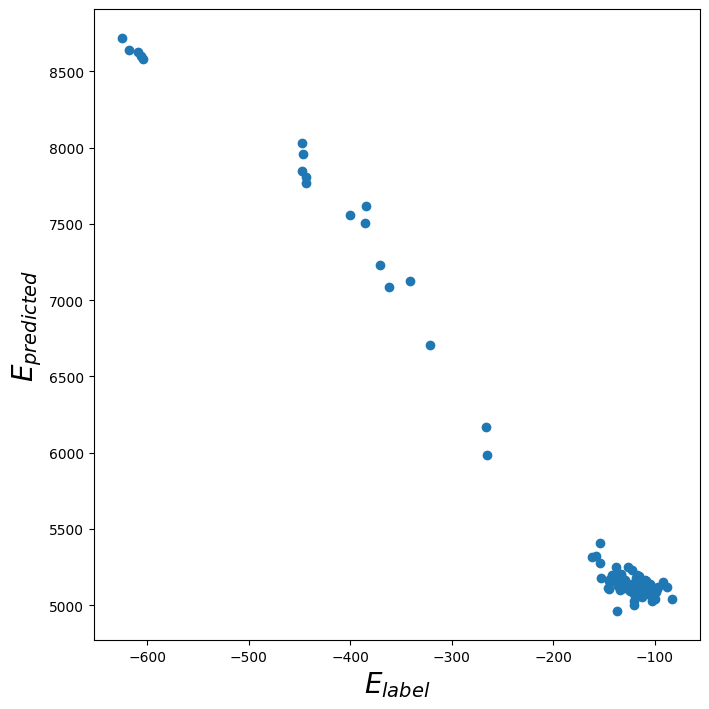

In [ ]:
n_predictions = 100
example_positions = positions[:n_predictions]
example_energies = energies[:n_predictions]

(predicted, edges_features), edges, edges_idx = vmap(train_energy_fn, (None, 0))(params, example_positions)
plt.plot(example_energies, predicted, 'o')

format_plot('$E_{label}$', '$E_{predicted}$')

finalize_plot((1, 1))

In [ ]:
@jit
def energy_loss(params, R,energy_targets):
  (predicted, edges_features), edges, edges_idx = vectorized_energy_fn(params, R)
  return np.mean((predicted - energy_targets) ** 2)


@jit
def loss(params, R, targets):
  return energy_loss(params, R, targets)

opt = optax.chain(optax.adam(lr))

@jit
def update_step(params, opt_state, R, labels):
  updates, opt_state = opt.update(grad(loss)(params, R, labels),
                                  opt_state)
  return optax.apply_updates(params, updates), opt_state

@jit
def update_epoch(params_and_opt_state, batches):
  def inner_update(params_and_opt_state, batch):
    params, opt_state = params_and_opt_state
    b_xs, b_labels = batch
    return update_step(params, opt_state, b_xs, b_labels), 0
  return lax.scan(inner_update, params_and_opt_state, batches)[0]

In [ ]:
dataset_size = positions.shape[0]

lookup = onp.arange(dataset_size)
onp.random.shuffle(lookup)

@jit
def make_batches(lookup):
  batch_Rs = []
  batch_Es = []

  for i in range(0, len(lookup), batch_size):
    if i + batch_size > len(lookup):
      break

    idx = lookup[i:i + batch_size]

    batch_Rs += [positions[idx]]
    batch_Es += [energies[idx]]
  return np.stack(batch_Rs), np.stack(batch_Es)

batch_Rs, batch_Es = make_batches(lookup)

In [ ]:
test_size = test_positions.shape[0]
lookuptest = onp.arange(test_size)
onp.random.shuffle(lookuptest)
@jit
def make_test_batches(lookuptest):
  test_Rs = []
  test_Es = []
  #batch_Fs = []

  for i in range(0, len(lookuptest), test_batch_size):
    if i + test_batch_size > len(lookuptest):
      break

    idx = lookuptest[i:i + test_batch_size]

    test_Rs += [test_positions[idx]]
    test_Es += [test_energies[idx]]

  return np.stack(test_Rs), np.stack(test_Es)

test_Rs, test_Es = make_test_batches(lookuptest)

In [ ]:
opt_state = opt.init(params)

train_energy_error = []
test_energy_error = []

old_time = time.perf_counter()
print('step\ttime/step\ttrain_loss\ttest_loss')
print('-----------------------------------------------------------------------')

best_val_loss = 9999
best_train_loss = 9999
count = 0
best_epo_id = 0
best_params = params

for iteration in range(train_epochs):
    train_energy_error += [float(np.sqrt(energy_loss(params, batch_Rs[0], batch_Es[0])))]
    test_energy_error += [float(np.sqrt(energy_loss(params, test_Rs[0], test_Es[0])))]

    params, opt_state = update_epoch((params, opt_state),
                                   (batch_Rs, batch_Es))

    onp.random.shuffle(lookup)
    batch_Rs, batch_Es = make_batches(lookup)
    onp.random.shuffle(lookuptest)
    test_Rs, test_Es = make_test_batches(lookuptest)


    if test_energy_error[-1] < best_val_loss:
        count = 0 #     early stopping counting clean up
        best_val_loss = test_energy_error[-1]
        best_train_loss = train_energy_error[-1]
        best_epo_id = iteration
        best_params = params
    else:
        count = count + 1 # early stopping counting

    if iteration % print_every ==0 and iteration >0:
         new_time = time.perf_counter()
         print('{}\t{:.3f}\t{:.3f}\t{:.3f}'.format(iteration, (new_time - old_time) / print_every, train_energy_error[iteration], test_energy_error[iteration]))
         old_time = new_time

step	time/step	train_loss	test_loss
-----------------------------------------------------------------------
150	1.953	12.298	11.386
300	1.949	4.345	4.195
450	1.928	5.769	7.213
600	1.919	6.423	8.238
750	1.907	4.611	6.847
900	1.913	5.552	4.613
1050	1.912	4.398	4.000


In [ ]:
train_energy_error[-1]

3.9825093746185303

In [ ]:
test_energy_error[-1]

6.0794477462768555

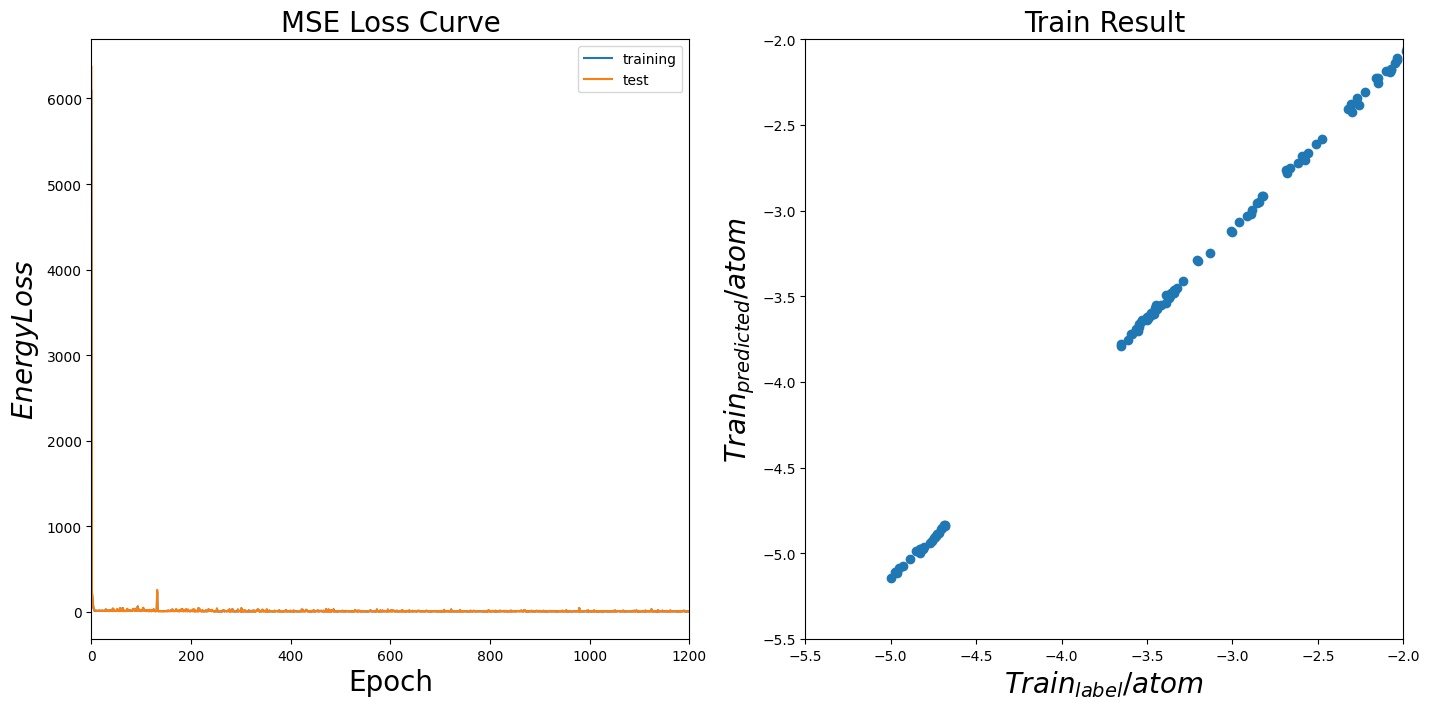

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(train_energy_error)
plt.plot(test_energy_error)
plt.title("MSE Loss Curve",fontsize=20)
plt.legend(['training', 'test'])
#plt.ylim([0, 2])
plt.xlim([0, train_epochs])
format_plot('Epoch', '$Energy Loss$')

plt.subplot(1, 2, 2)

n_predictions = 400
example_positions = positions[:n_predictions]
example_energies = energies[:n_predictions]
(predicted_energies, edge_features), edges, edges_idx = vectorized_energy_fn(best_params, example_positions)
plt.plot(example_energies/N, predicted_energies/N, 'o')
plt.xlim(-5.5,-2.0)
plt.ylim(-5.5,-2.0)
plt.title("Train Result",fontsize=20)
format_plot('$Train_{label}/atom$', '$Train_{predicted}/atom$')


finalize_plot((2, 1))


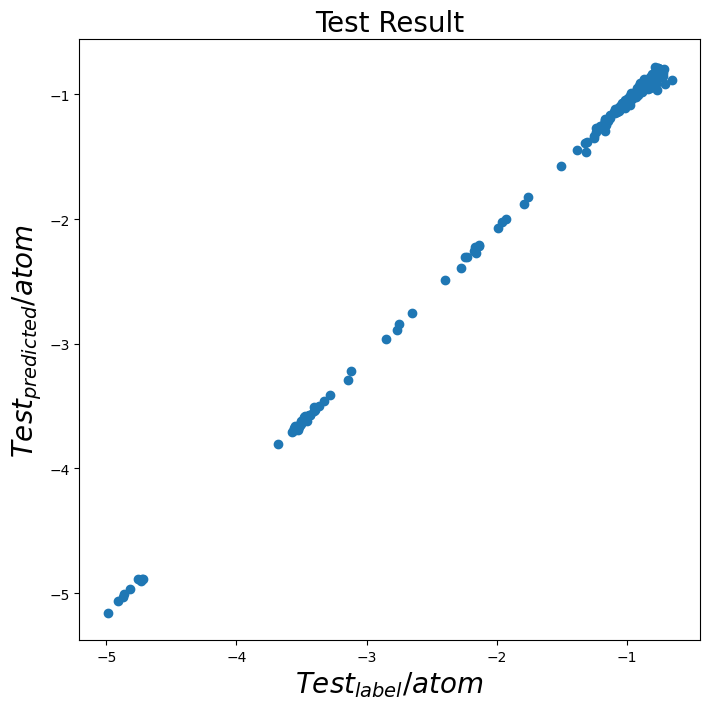

In [ ]:
(predicted_testenergies, edge_features), edges, edges_idx  = vectorized_energy_fn(best_params, test_positions[0:200])
plt.plot(test_energies[0:200]/128, predicted_testenergies/128, 'o')
plt.title("Test Result",fontsize=20)
format_plot('$Test_{label}/atom$', '$Test_{predicted}/atom$')
finalize_plot((1, 1))

In [ ]:
# Section: Store the model parameters
# Note: This code is commented out to avoid accidental overwriting of existing files.
'''
import pickle
with open('/content/drive/My Drive/GNNWithSymbolicRegression/data/GNN_Data/real_coor_mygraphnet_noglobal_directr_embeding.pickle', 'wb') as files:
    pickle.dump(best_params, files)
'''

# Record Edge Feature

Extract and store edge features from high and low-temperature datasets based on pre-trained GNN


In [ ]:
# Load pre-trained model parameters
with open('/content/drive/My Drive/GNNWithSymbolicRegression/data/GNN_Data/real_coor_mygraphnet_noglobal_directr_embeding.pickle', 'rb') as files:
    params = pickle.load(files)

"\nimport pickle\nwith open('/content/drive/My Drive/Ruoxia/GNN JAX/Fine GNN model/trained_params/real_coor_mygraphnet_noglobal_directr_embeding.pickle', 'rb') as files:\n    params = pickle.load(files)\n"

In [ ]:
# Load datasets and process coordinates and energies

N = 128
box_size_train = 1.3750448600704519e+01 - 4.1751703855234110e+00

PE_high = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/coverted_npy/pureljenergy_128_highT.npy')
Pos_high = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/coverted_npy/pureljposition_128_highT.npy')
data_number_high = Pos_high.shape[0]
PE_high = PE_high*N
PE_high = np.array(PE_high)
Pos_high = np.array(Pos_high)                #frational coordinate
Pos_high = Pos_high * box_size_train         #original coordinate

PE_low = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/coverted_npy/pureljenergy_128_lowT.npy')
Pos_low = onp.load('/content/drive/My Drive/GNNWithSymbolicRegression/data/MD_Data/coverted_npy/pureljposition_128_lowT.npy')
data_number_low = Pos_low.shape[0]
PE_low = PE_low*N
PE_low = np.array(PE_low)
Pos_low = np.array(Pos_low)                #frational coordinate
Pos_low = Pos_low * box_size_train         #original coordinate

In [ ]:
high_size = Pos_high.shape[0]
lookuptest_record_high = onp.arange(high_size)
onp.random.shuffle(lookuptest_record_high)
data_batch = 10

In [ ]:
# Utility functions for batch generation
#For high temperature dataset
@jit
def make_train_batches_record_high(lookuptest_record_high):
  test_Rs = []
  test_Es = []
  #batch_Fs = []

  for i in range(0, len(lookuptest_record_high), data_batch):
    if i + data_batch > len(lookuptest_record_high):
      break

  idx = lookuptest_record_high[i:i + data_batch]

  test_Rs += [Pos_high[idx]]
  test_Es += [PE_high[idx]]

  return np.stack(test_Rs), np.stack(test_Es)

def get_messages_high(params):

    def get_message_info(edge_features, edges, edge_idx, feature_number = 1):
        #dr_2 = space.square_distance(edges)
        #if dr_2 < (r_cutoff ** 2):
        edge_features = edge_features.reshape(-1, feature_number)
        edges = edges.reshape(-1, 1)
        messages = onp.concatenate((edges, edge_features), axis = -1)

        #columns = [elem for elem in 'dx dy dz'.split(' ')]
        columns = ['dr']
        columns += ['e%d'%(k,) for k in range(feature_number)]
        return pd.DataFrame(
            data=messages,
            columns=columns)
        #return

    msg_info = []
    test_Rs_record, test_Es_record = make_train_batches_record_high(lookuptest_record_high)
    (predicted, edge_features), edges, edges_idx = vectorized_energy_fn(params, test_Rs_record[0])
    msg_info.append(get_message_info(edge_features, edges, edges_idx))
    onp.random.shuffle(lookuptest_record_high)
    #test_Rs_record, test_Es_record = make_test_batches_record(lookuptest_record)

    msg_info = pd.concat(msg_info)
    #msg_info['r'] = onp.sqrt(
    #        (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
    #    )

    return msg_info

In [ ]:
low_size = Pos_low.shape[0]
lookuptest_record_low = onp.arange(low_size)
onp.random.shuffle(lookuptest_record_low)
data_batch = 10

## Utility functions for batch generation
#For low temperature dataset
@jit
def make_train_batches_record_low(lookuptest_record_low):
  test_Rs = []
  test_Es = []
  #batch_Fs = []

  for i in range(0, len(lookuptest_record_low), data_batch):
    if i + data_batch > len(lookuptest_record_low):
      break

  idx = lookuptest_record_low[i:i + data_batch]

  test_Rs += [Pos_low[idx]]
  test_Es += [PE_low[idx]]

  return np.stack(test_Rs), np.stack(test_Es)

def get_messages_low(params):

    def get_message_info(edge_features, edges, edge_idx, feature_number = 1):
        #dr_2 = space.square_distance(edges)
        #if dr_2 < (r_cutoff ** 2):
        edge_features = edge_features.reshape(-1, feature_number)
        edges = edges.reshape(-1, 1)
        messages = onp.concatenate((edges, edge_features), axis = -1)

        #columns = [elem for elem in 'dx dy dz'.split(' ')]
        columns = ['dr']
        columns += ['e%d'%(k,) for k in range(feature_number)]
        return pd.DataFrame(
            data=messages,
            columns=columns)
        #return

    msg_info = []
    test_Rs_record, test_Es_record = make_train_batches_record_low(lookuptest_record_low)
    (predicted, edge_features), edges, edges_idx = vectorized_energy_fn(params, test_Rs_record[0])
    msg_info.append(get_message_info(edge_features, edges, edges_idx))
    onp.random.shuffle(lookuptest_record_low)
    #test_Rs_record, test_Es_record = make_test_batches_record(lookuptest_record)

    msg_info = pd.concat(msg_info)
    #msg_info['r'] = onp.sqrt(
    #        (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
    #    )

    return msg_info

In [ ]:
# Generate edge features for both datasets

recorded_models = []
messages_over_time_high = get_messages_high(best_params)
messages_over_time_low = get_messages_low(best_params)
recorded_models = params

In [ ]:
# Save the edge features as GNN result
with open('/content/drive/My Drive/GNNWithSymbolicRegression/data/GNN_Data/GNN_Record_highTemp.pickle', 'wb') as files:
    pickle.dump(messages_over_time_high, files)

with open('/content/drive/My Drive/Ruoxia/GNNWithSymbolicRegression/data/GNN_Data/GNN_Record_lowTemp.pickle', 'wb') as files:
    pickle.dump(messages_over_time_low, files)